In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import basinhopping
import skimage
import IPython.display as disp
from math import floor

In [5]:
# DATASET_PATH = "/home/quesneay/mohit/final/dataset_cat/separated/mask/"
DATASET_PATH = "/home/aymeric/OMA/projet_rech/dataset/mask/"

In [6]:
def display_progress(i, maxi, length):
    disp.display('[' + "".join(
        ['=' for j in range(floor(length*i/maxi))]
    ) + '>' + "".join(
        [' ' for j in range(floor(length*i/maxi)+1, length)]
    ) + ']', str(floor(length*i/maxi)), '%')
    disp.clear_output(wait=True)

In [4]:
from os import listdir

file_list = listdir(DATASET_PATH)
CoMs = {}

FileNotFoundError: [Errno 2] No such file or directory: '/home/quesneay/mohit/final/dataset_cat/separated/mask/'

In [5]:
from skimage.measure import find_contours

def find_centers_of_mass(img, thresh=5000):
    contours = find_contours(img, level=0.5)
    centers_of_mass = []
    for i, contour in enumerate(contours):
        int_contour = np.ceil(contour).astype('uint16')
        mat = np.zeros(eroded_image.shape)
        mat[int_contour[:,0], int_contour[:,1]] = 1
        bin_holes = binary_fill_holes(mat)
        m = moments(bin_holes)
        if m[0,0] > thresh:
            x = int(m[0,1]/m[0,0])
            y = int(m[1,0]/m[0,0])
            centers_of_mass.append((x, y))
    return centers_of_mass

In [6]:
from json import dumps, load
from pathlib import Path

if Path("centers_of_mass.json").exists():
    with open("centers_of_mass.json", 'r') as coms_fd:
        CoMs = load(coms_fd)
        print('Loaded centers of mass from file.')
else:
    for i, file in enumerate(file_list):
        img = plt.imread(DATASET_PATH + '/' + file)[:,:,0]
        CoMs[file] = find_centers_of_mass(img)
        display_progress(i, len(file_list), 50)
    with open("centers_of_mass.json", 'w') as fd:
        fd.write(dumps(CoMs))

Loaded centers of mass from file.


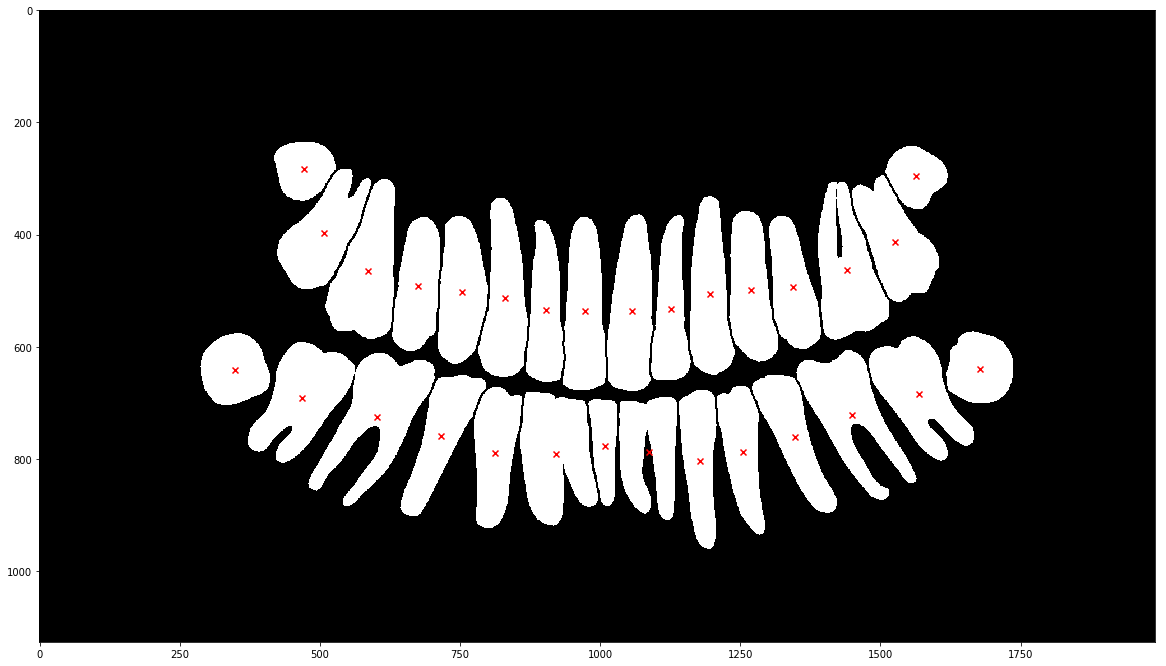

In [7]:
plt.figure(figsize=(20,20))
n_file = 275
file = file_list[n_file]
img = plt.imread(DATASET_PATH + '/' + file)
plt.imshow(img)
centers = np.array(CoMs[file])
plt.scatter(centers[:,0], centers[:,1], marker='x', color='red')

In [8]:
len(CoMs)

276

In [9]:
len(list(filter(lambda x: len(x) == 32, CoMs.values())))

191

In [39]:
def sort_dentier(dentier):
    # sorts un dentier by finding the nearest neighbor
    N = len(dentier)
    indices = []
    dist = np.sum(np.abs(dentier),axis=1)
    indices.append(np.argmax(dist))
    for i in range(N//2-1):
        s = np.inf
        mini = 0
        for j in range(N):
            norm = np.linalg.norm(dentier[indices[-1]] - dentier[j])
            if norm < s and (j not in indices):
                mini = j
                s = norm
        indices.append(mini)
    dist = np.sum(np.abs(dentier),axis=1)
    indices.append(np.argmin(dist))
    for i in range(N//2+1, N):
        s = np.inf
        mini = 0
        for j in range(N):
            norm = np.linalg.norm(dentier[indices[-1]] - dentier[j])
            if norm < s and (j not in indices):
                mini = j
                s = norm
        indices.append(mini)
    return indices

In [40]:
sorted_centers = sort_dentier(centers)
lower_teeth = centers[sorted_centers[:14]]
upper_teeth = centers[sorted_centers[14:]]

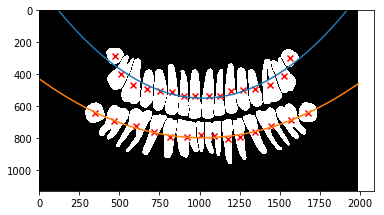

In [51]:
from numpy.polynomial.polynomial import Polynomial
plt.imshow(img)
plt.scatter(centers[:,0], centers[:,1], marker='x', color='red')
xx = np.linspace(0, img.shape[1])
upper_pol = Polynomial.fit(upper_teeth[:,0], upper_teeth[:,1], [0, 1, 2])
yy = upper_pol(xx)
plt.plot(xx, yy)
lower_pol = Polynomial.fit(lower_teeth[:,0], lower_teeth[:,1], [0, 1, 2])
yy = lower_pol(xx)
plt.plot(xx, yy)
plt.gca().set_ylim(img.shape[0], 0);

In [69]:
lower_min = -lower_pol.convert().coef[1]/2/lower_pol.convert().coef[2]
upper_min = -upper_pol.convert().coef[1]/2/upper_pol.convert().coef[2]
x_mean = (lower_min + upper_min)/2
y_gap = upper_min - lower_min

In [71]:
len(centers)

30

In [67]:
lower_pol.convert().coef

array([ 4.28542575e+02,  7.22051243e-01, -3.55121773e-04])

In [106]:
from numpy.polynomial.polynomial import Polynomial

def transform_quad(centers, gap = 1, x_scale = 1):
    # Unfit because some x-rays display no curvature so fitting a quadratic
    # is ill-conditioned
    assert len(centers) == 32
    sorted_centers = sort_dentier(centers)
    lower_teeth = centers[sorted_centers[:16]]
    upper_teeth = centers[sorted_centers[16:]]
    upper_pol = Polynomial.fit(upper_teeth[:,0], upper_teeth[:,1], [0, 2])
    lower_pol = Polynomial.fit(lower_teeth[:,0], lower_teeth[:,1], [0, 2])
    lower_min = -lower_pol.convert().coef[1]/2/lower_pol.convert().coef[2]
    upper_min = -upper_pol.convert().coef[1]/2/upper_pol.convert().coef[2]
    x_mean = (lower_min + upper_min)/2
    y_lower_mean = lower_pol(x_mean)
    y_gap = upper_min - lower_min
    centers = centers - (x_mean, y_lower_mean)
    
    centers[:,1] /= y_gap
    # Normalize horizontally by the order coefficient of the polynomial
    centers[:,0] /= np.sqrt(np.abs(lower_pol.convert().coef[2]))
    
    return centers, (x_mean, y_lower_mean)

In [47]:
_32_teeth = []
not_32_teeth = []
for key in CoMs.keys():
    if len(CoMs[key]) == 32:
        _32_teeth.append(key)
    else:
        not_32_teeth.append(key)

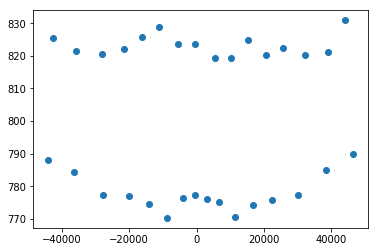

In [123]:
tooth_index = 1
centers = np.array(CoMs[_32_teeth[tooth_index]])
img = plt.imread(DATASET_PATH + '/' + _32_teeth[tooth_index])
transf_centers, shift = transform(centers)
transf_centers += shift
plt.scatter(transf_centers[:,0],transf_centers[:,1])

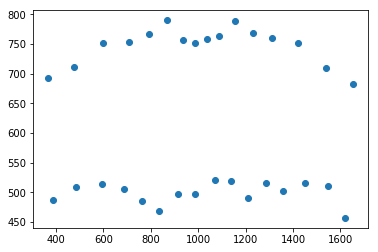

In [124]:
plt.scatter(centers[:,0],centers[:,1])

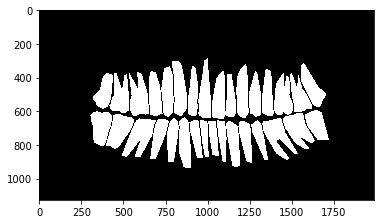

In [125]:
plt.imshow(img)

---
## Robust

In [17]:
from scipy.stats import trim_mean, iqr
def transform_robust(centers):
    centers = centers.astype('float64')
    x_mean = trim_mean(centers[:,0], 0.2)
    x_iqr = iqr(centers[:,0])
    centers[:,0] -= x_mean
    centers[:,0] /= x_iqr
    y_max = np.max(centers[:,1])
    y_min = np.min(centers[:,1])
    centers[:,1] -= y_min
    centers[:,1] /= (y_max - y_min)
    return centers, (x_mean, y_min), (x_iqr, (y_max - y_min))

In [31]:
tooth_index = 2
centers = np.array(CoMs[_32_teeth[tooth_index]])
img = plt.imread(DATASET_PATH + '/' + _32_teeth[tooth_index])

In [32]:
rob_centers, shift, scale = transform_robust(centers)

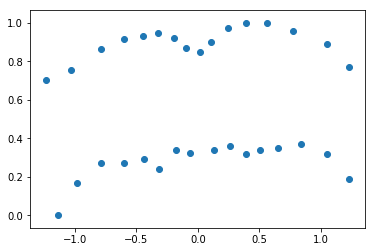

In [33]:
plt.scatter(rob_centers[:,0], rob_centers[:,1])

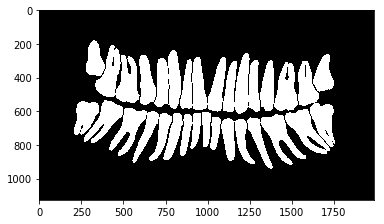

In [34]:
plt.imshow(img)

In [45]:
transformed_centers = []
mean = np.zeros((32,2))
for file in _32_teeth:
    centers = np.array(CoMs[file])
    sorted_centers = centers[sort_dentier(centers)]
    rob_centers, shift, scale = transform_robust(sorted_centers)
    transformed_centers.append(rob_centers)
    mean += rob_centers
mean /= len(_32_teeth)

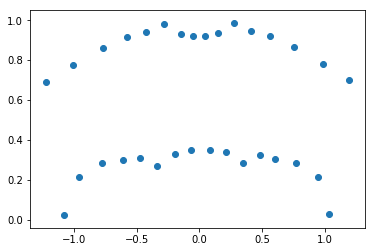

In [46]:
plt.scatter(mean[:,0], mean[:,1])

In [50]:
tooth_ind = 0
img = plt.imread(DATASET_PATH + '/' + not_32_teeth[tooth_ind])
transf, _, _ = transform_robust(np.array(CoMs[not_32_teeth[tooth_ind]]))

(1.2, -0.2)

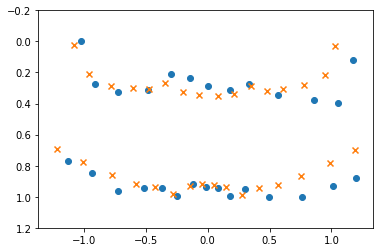

In [54]:
plt.scatter(transf[:,0], transf[:,1])
plt.scatter(mean[:,0], mean[:,1], marker='x')
plt.gca().set_ylim(1.2, -0.2)

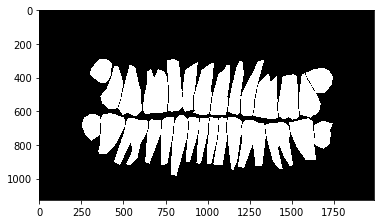

In [53]:
plt.imshow(img)